In [34]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os
import pickle

import sys
from pathlib import Path

PROJECT_ROOT = str(Path.cwd().parent.resolve())
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import Class_site as site
import free_fermion_representation as f
import variables_phasediagram_simulation as vps

## Level spacing ratio

find level spacing ratio for different unitaries in the range between T =0.67 and T = 1, Delta = 0...0.5

In [35]:
def order_parameter_delta_T(model, fgs, T, delta, edgepar = None):

    _, _, _, R0 = fgs.floquet_operator_ham(T)
    _, _, _, Re = fgs.floquet_operator_ham(T, anyon=True)
    
    if delta != 0:
        V0 = f.generate_disorder_term(model, fgs.Cov, delta, edgepar = edgepar)
        Ve = f.generate_disorder_term(model, fgs.Cov, delta, type="Anyon", edgepar = edgepar)
        R_V0 = f.floquet_operator(V0, T, alpha = np.pi/4.)
        R_Ve = f.floquet_operator(Ve, T, alpha = np.pi/4.)
        R_V0_R0 = R_V0 @ R0
        R_Ve_Re = R_Ve @ Re
    else:
        R_V0_R0 = R0
        R_Ve_Re = Re

    return R_V0_R0, R_Ve_Re

In [36]:
def level_spacing_ratio(op, T):
    """
    Compute level-spacing ratio for eigenphases of unitary `op`.

    Returns:
      mean_r : float
        Average of r_n = min(s_n, s_{n+1})/max(s_n, s_{n+1}) over consecutive spacings.
      r_vals : ndarray
        Array of r_n values.
    Notes:
      - Uses principal angles via np.angle (in (-pi,pi]) and accounts for the circular wrap.
      - Converts phase spacings to "energies" by dividing by T.
    """
    
    ev = np.linalg.eigvals(op)
    #print(ev)
    if ev.size < 3:
        return np.nan, np.array([])

    angles = np.angle(ev)                       # principal values in (-pi, pi]
    #print(angles)
    angles_sorted = np.sort(angles)             # sort on the circle (linear order)
    #print(angles_sorted)
    spacings = np.diff(angles_sorted)           # interior spacings
    wrap_spacing = (angles_sorted[0] + 2*np.pi) - angles_sorted[-1]
    spacings = np.concatenate((spacings, [wrap_spacing]))  # include wrap-around
    #print(spacings)

    spacings = spacings / T                     # convert to energy units if desired

    # compute r_n = min(s_n, s_{n+1})/max(s_n, s_{n+1})
    if spacings.size < 2:
        return np.nan, np.array([])
    s1 = spacings[:-1]
    s2 = spacings[1:]
    r_vals = np.minimum(s1, s2) / np.maximum(s1, s2)

    mean_r = np.mean(r_vals)
    return mean_r, r_vals

In [37]:
oper = np.array([[np.exp(1j * 0.1), 0, 0],
                 [0, np.exp(1j * 1.5), 0],
                 [0, 0, np.exp(1j * 2.8)]])

print(oper)

[[ 0.99500417+0.09983342j  0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.0707372 +0.99749499j  0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j         -0.94222234+0.33498815j]]


In [38]:
mean_r, r_vals = level_spacing_ratio(oper, T=1.0)
print()
print("Mean level-spacing ratio:", mean_r)
print("Level-spacing ratios:", r_vals)


Mean level-spacing ratio: 0.6456885568061953
Level-spacing ratios: [0.92857143 0.36280569]


In [39]:
def lsr_diagram_total(delta_list, T_list, model, fgs, N_disorder, save_dir=None):
    """
    Generate level-spacing ratio diagram over ranges of disorder strength and period.

    Parameters:
      delta_list : list or ndarray
        List of disorder strengths to sample.
      T_list : list or ndarray
        List of periods to sample.
      model : Class_site.Site
        The model defining the system.
      fgs : free_fermion_representation.FreeFermionRepresentation
        The free fermion representation of the system.
      N_disorder : int
        Number of disorder realizations to average over.
    """
    lsr_matrix_0 = np.zeros((len(delta_list), len(T_list)))
    lsr_matrix_e = np.zeros((len(delta_list), len(T_list)))

    for i, delta in enumerate(tqdm(delta_list, desc="Deltas")):
        for j, T in enumerate(tqdm(T_list, desc=f"T for delta={delta}", leave=False)):
            r_vals_0 = []
            r_vals_e = []
            for _ in range(N_disorder):
                R_V0_R0, R_Ve_Re = order_parameter_delta_T(model, fgs, T, delta)
                mean_r_0, r_values_0 = level_spacing_ratio(R_V0_R0, T)
                mean_r_e, r_values_e = level_spacing_ratio(R_Ve_Re, T)
                if not np.isnan(mean_r_0):
                    r_vals_0.append(mean_r_0)
                if not np.isnan(mean_r_e):
                    r_vals_e.append(mean_r_e)
            lsr_matrix_0[i, j] = np.mean(r_vals_0) if r_vals_0 else np.nan
            lsr_matrix_e[i, j] = np.mean(r_vals_e) if r_vals_e else np.nan
    
    if save_dir is not None:
        general_dir = "lsr_matrices"
        full_dir = os.path.join(general_dir, save_dir)
        os.makedirs(full_dir, exist_ok=True)
        with open(os.path.join(full_dir, "lsr_matrix_0.pkl"), "wb") as ffile:
            pickle.dump(lsr_matrix_0, ffile)
        with open(os.path.join(full_dir, "lsr_matrix_e.pkl"), "wb") as ffile:
            pickle.dump(lsr_matrix_e, ffile)

    return lsr_matrix_0, lsr_matrix_e


In [40]:
def lsr_diagram_0(delta_list, T_list, model, fgs, N_disorder, save_dir=None):
    """
    Generate level-spacing ratio diagram over ranges of disorder strength and period.

    Parameters:
      delta_list : list or ndarray
        List of disorder strengths to sample.
      T_list : list or ndarray
        List of periods to sample.
      model : Class_site.Site
        The model defining the system.
      fgs : free_fermion_representation.FreeFermionRepresentation
        The free fermion representation of the system.
      N_disorder : int
        Number of disorder realizations to average over.
    """
    lsr_matrix_0 = np.zeros((len(delta_list), len(T_list)))

    for i, delta in enumerate(tqdm(delta_list, desc="Deltas")):
        for j, T in enumerate(tqdm(T_list, desc=f"T for delta={delta}", leave=False)):
            r_vals_0 = []
            for _ in range(N_disorder):
                R_V0_R0, R_Ve_Re = order_parameter_delta_T(model, fgs, T, delta)
                mean_r_0, r_values_0 = level_spacing_ratio(R_V0_R0, T)
                if not np.isnan(mean_r_0):
                    r_vals_0.append(mean_r_0)
            lsr_matrix_0[i, j] = np.mean(r_vals_0) if r_vals_0 else np.nan
        
    if save_dir is not None:
        general_dir = "lsr_matrices"
        full_dir = os.path.join(general_dir, save_dir)
        os.makedirs(full_dir, exist_ok=True)
        with open(os.path.join(full_dir, "lsr_matrix_0.pkl"), "wb") as ffile:
            pickle.dump(lsr_matrix_0, ffile)


    return lsr_matrix_0


In [46]:
delta_list = vps.delta_list_3
T_list = vps.T_list_2[::-1]

In [48]:
print(T_list)

[0.1, 0.13750000000000007, 0.17500000000000004, 0.21250000000000002, 0.25, 0.2875, 0.32500000000000007, 0.36250000000000004, 0.4, 0.4375, 0.475, 0.5125, 0.55, 0.5875, 0.625, 0.6625000000000001, 0.7, 0.7375, 0.775, 0.8125, 0.85, 0.8875, 0.925, 0.9625, 1.0]


In [49]:
model = site.SitesOBC(Npx = 21, Npy = 21, edge = True)
fgs = f.FermionicGaussianRepresentation(model)

In [ ]:
lsr_matrix_0 = lsr_diagram_0(delta_list, T_list, model, fgs, N_disorder=1, save_dir = "size21_delta3_T2_Ndisorder1")

Deltas:   0%|          | 0/11 [00:00<?, ?it/s]

T for delta=0:   0%|          | 0/25 [00:00<?, ?it/s]

/var/folders/6j/zg3nz4053f97fyqx4w2b6pxc0000gn/T/ipykernel_73904/3139785563.py:36: RuntimeWarning: invalid value encountered in divide
  r_vals = np.minimum(s1, s2) / np.maximum(s1, s2)


T for delta=0.05:   0%|          | 0/25 [00:00<?, ?it/s]

T for delta=0.1:   0%|          | 0/25 [00:00<?, ?it/s]

T for delta=0.15:   0%|          | 0/25 [00:00<?, ?it/s]

T for delta=0.2:   0%|          | 0/25 [00:00<?, ?it/s]

T for delta=0.25:   0%|          | 0/25 [00:00<?, ?it/s]

T for delta=0.3:   0%|          | 0/25 [00:00<?, ?it/s]

T for delta=0.35:   0%|          | 0/25 [00:00<?, ?it/s]

T for delta=0.4:   0%|          | 0/25 [00:00<?, ?it/s]

T for delta=0.45:   0%|          | 0/25 [00:00<?, ?it/s]

T for delta=0.5:   0%|          | 0/25 [00:00<?, ?it/s]

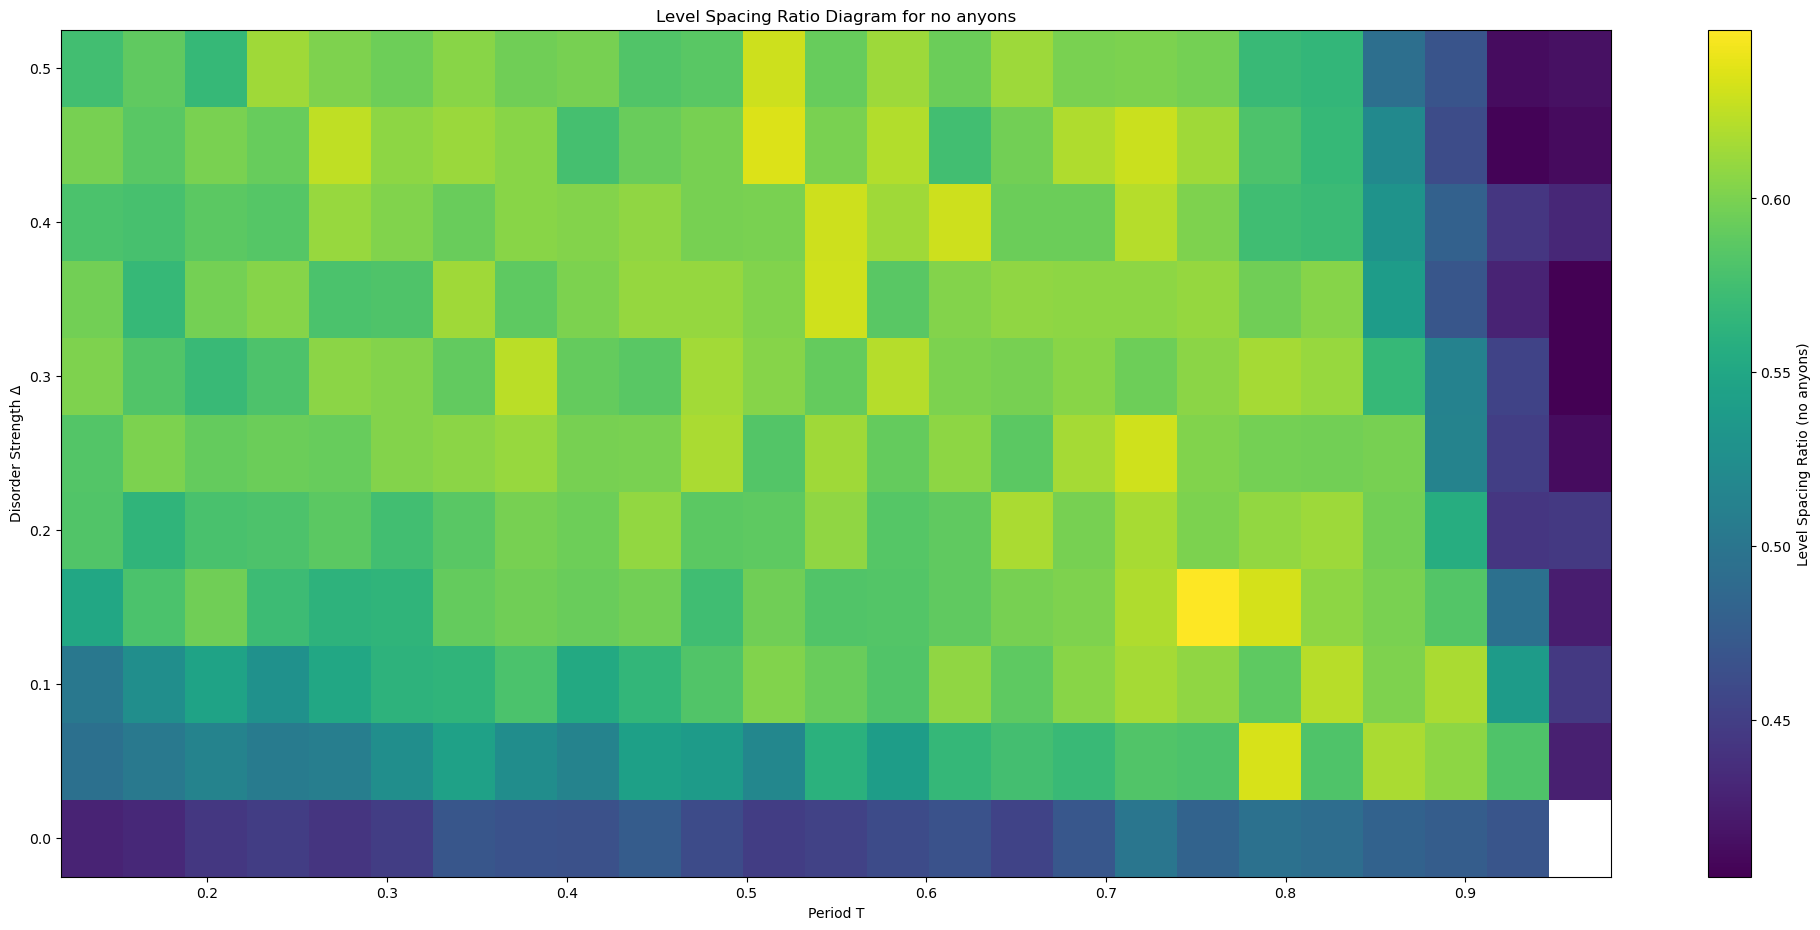

In [ ]:
figsize = (len(T_list), len(delta_list))

deltaT = np.abs(T_list[1]-T_list[0])/2
deltadelta = (delta_list[1]-delta_list[0])/2

T_start = T_list[0]+deltaT
T_finish = T_list[-1]-deltaT    

plt.figure(figsize=figsize)
plt.imshow(lsr_matrix_0, 
           aspect='auto',
           origin='lower',   
           extent=[T_start, T_finish, delta_list[0]-deltadelta, delta_list[-1]+deltadelta],
           cmap='viridis')
plt.colorbar(label='Level Spacing Ratio (no anyons)')
plt.xlabel('Period T')
plt.ylabel('Disorder Strength Δ')
plt.title('Level Spacing Ratio Diagram for no anyons')
plt.savefig('size21_lsr_0_delta_list_3_T_list_2.png')

In [ ]:
figsize = (len(T_list), len(delta_list))

deltaT = np.abs(T_list[1]-T_list[0])/2
deltadelta = (delta_list[1]-delta_list[0])/2

T_start = T_list[0]+deltaT
T_finish = T_list[-1]-deltaT    

plt.figure(figsize=figsize)
plt.imshow(lsr_matrix_e, 
           aspect='auto',
           origin='lower',   
           extent=[T_start, T_finish, delta_list[0]-deltadelta, delta_list[-1]+deltadelta],
           cmap='viridis')
plt.colorbar(label='Level Spacing Ratio (e anyon)')
plt.xlabel('Period T')
plt.ylabel('Disorder Strength Δ')
plt.title('Level Spacing Ratio Diagram for e anyon') 

## Entanglement entropy